In [1]:
import pathlib
import os
if 'TSL_SCHOOL_DIR' in os.environ:
    if any( (p/".git").is_dir() for p in (pathlib.Path(".").absolute().resolve()/"dummy").parents ):
        raise RuntimeError('Please copy notebook to a work directory')

## Simplified ESS Model

In this notebook we will use a simplified ESS model to practice model conversion and importing. This model includes the current upper liquid hydrogen, flat moderator, and the lower, liquid deuterium, volumetric moderator proposed in HighNESS.

In [2]:
import openmc
import NCrystal as NC
import NCrystal.plot as ncplot
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
openmc.config['cross_sections'] = '/home/student/tsl_software/endfb-viii.0-hdf5/cross_sections.xml'

We will start by adding the NCMAT files for liquid hydrogen and deuterium from the Spallation Physics Group, from the [ESS SPG Gitlab Repository](https://git.esss.dk/spallation-physics-group/coldmoderators):

In [3]:
import urllib
import shutil

all_ncmat_files = [f.name for f in NC.browseFiles()]

new_files = {'ESS-oH2-20K.ncmat':'https://git.esss.dk/spallation-physics-group/coldmoderators/-/raw/main/LiquidHydrogen/ESS-oH2-20K.ncmat',
             'ESS-pH2-20K.ncmat':'https://git.esss.dk/spallation-physics-group/coldmoderators/-/raw/main/LiquidHydrogen/ESS-pH2-20K.ncmat',
             'ESS-oD2-19K.ncmat':'https://git.esss.dk/spallation-physics-group/coldmoderators/-/raw/main/LiquidDeuterium/ESS-oD2-19K.ncmat',
             'ESS-pD2-19K.ncmat':'https://git.esss.dk/spallation-physics-group/coldmoderators/-/raw/main/LiquidDeuterium/ESS-pD2-19K.ncmat',
             'ESS-oD2-20K.ncmat':'https://git.esss.dk/spallation-physics-group/coldmoderators/-/raw/main/LiquidDeuterium/ESS-oD2-20K.ncmat',
             'ESS-pD2-20K.ncmat':'https://git.esss.dk/spallation-physics-group/coldmoderators/-/raw/main/LiquidDeuterium/ESS-pD2-20K.ncmat'}

for file, url in new_files.items():
    if file not in all_ncmat_files:
        print(f'Retrieving {file}...')
        urllib.request.urlretrieve(url, file)
        shutil.copy2(file, os.environ['NCRYSTAL_DATADIR'])
        os.remove(file)

Our base model was generated using the [OpenMC / MCNP Adapter](https://github.com/openmc-dev/openmc_mcnp_adapter). We can import the geometry and materials using the `from_xml()` method:

In [4]:
# Import geometry converted from MCNP input
geo = openmc.Geometry.from_xml('geometry_converted.xml', materials='materials_converted.xml')

We can plot the geometry:

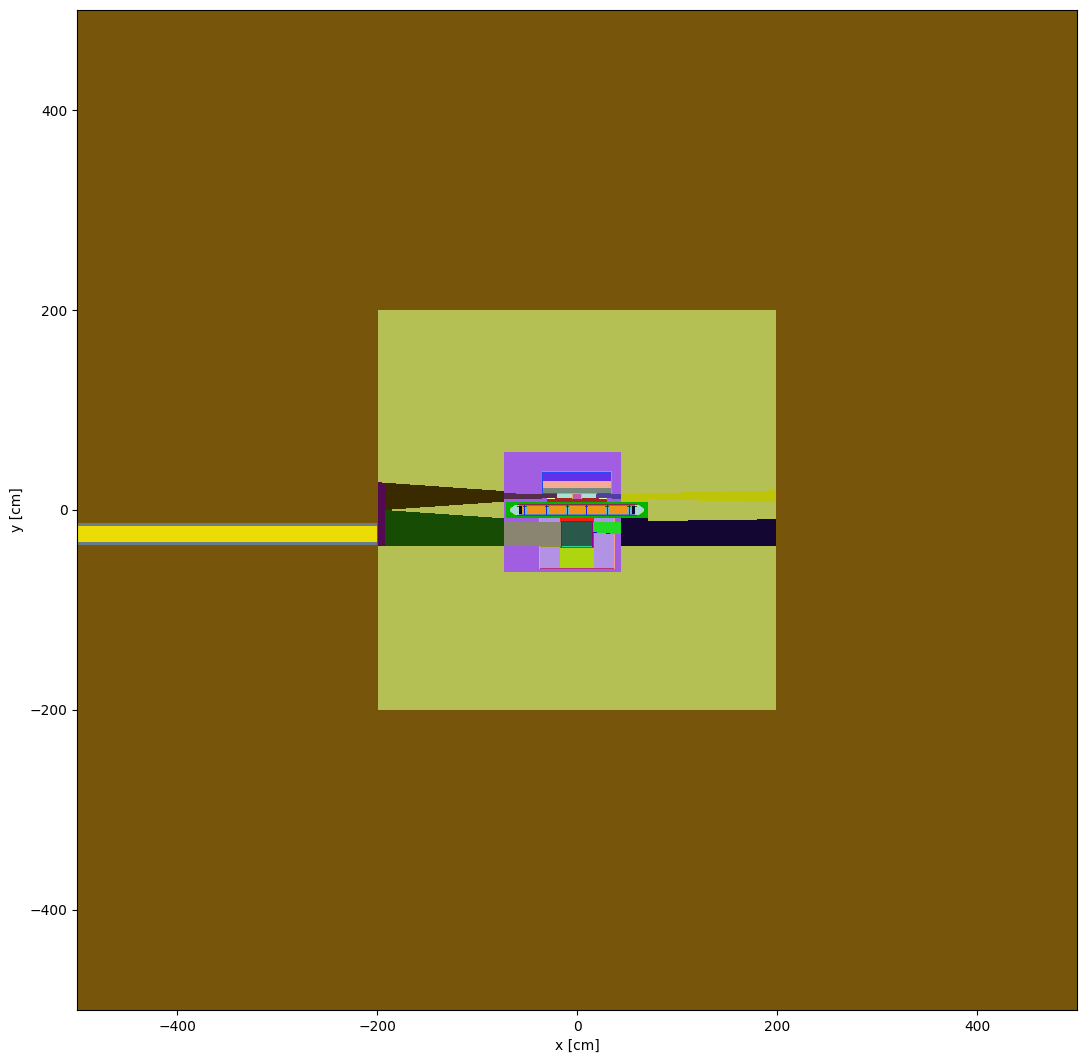

In [5]:
geo.root_universe.plot(width=(1000,1000), pixels=(1000,1000), color_by='cell', basis='xy')

Since the geometry comes from MCNP, it does not contain a boundary conditions. We will, create a new cell, fill it with the root universe of the imported geometry and create a new `Geometry` object.

It is very important to set the `merge_surfaces` property to avoid conflicts from redundant surfaces generated by MCNP:

In [6]:
# Create new geometry with outer sphere with boundary conditions

big_sphere = openmc.Sphere(r=500, boundary_type='vacuum')
cell1 = openmc.Cell(region=-big_sphere, fill=geo.root_universe)
uni1 = openmc.Universe(cells=[cell1])
new_geo = openmc.Geometry(root=uni1)
#
# Very important option:
# Get rid of redundant surfaces
#
new_geo.merge_surfaces=True 

We can do a few more plots:

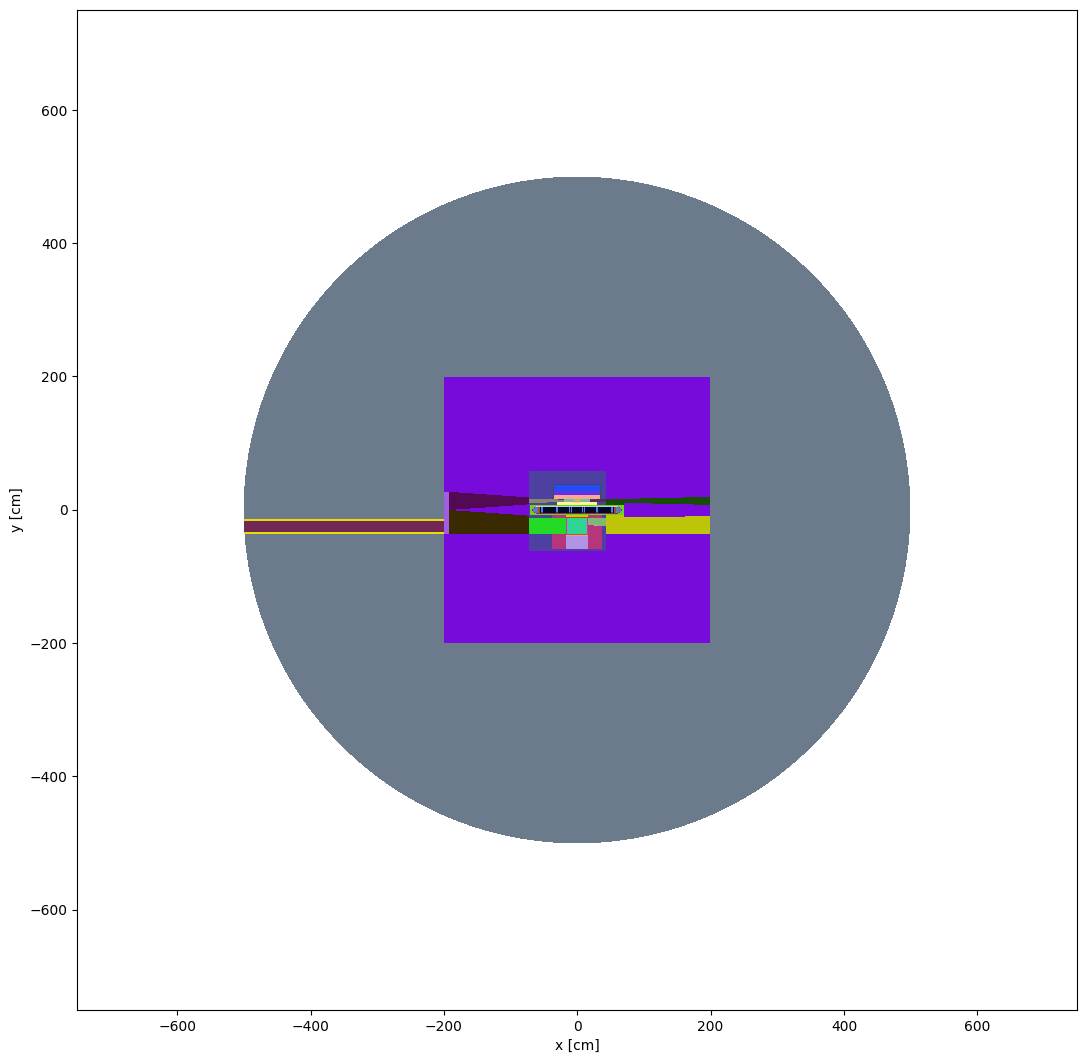

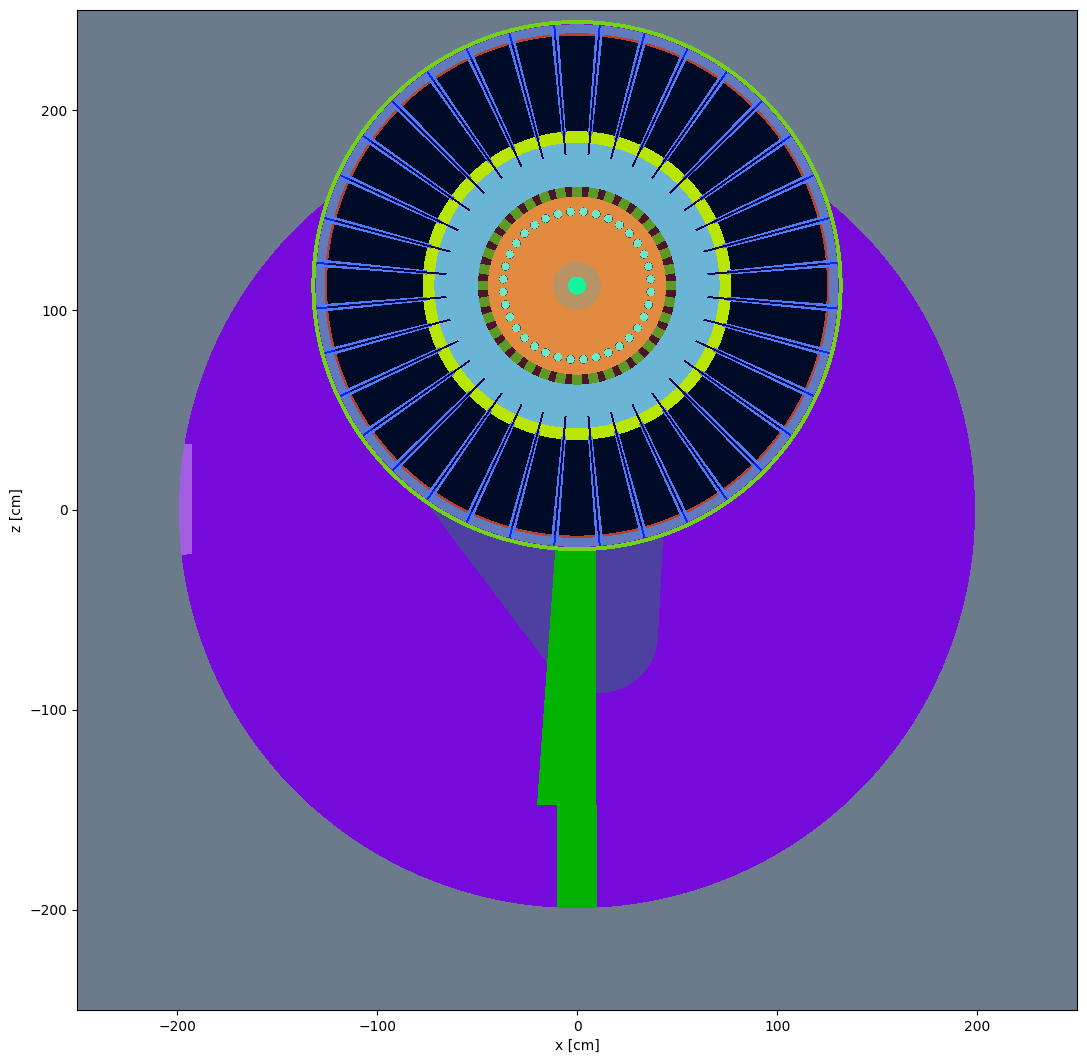

In [7]:
uni1.plot(width=(1500,1500), pixels=(1000,1000), color_by='cell', basis='xy')
uni1.plot(width=(500,500), pixels=(1000,1000), color_by='cell', basis='xz')

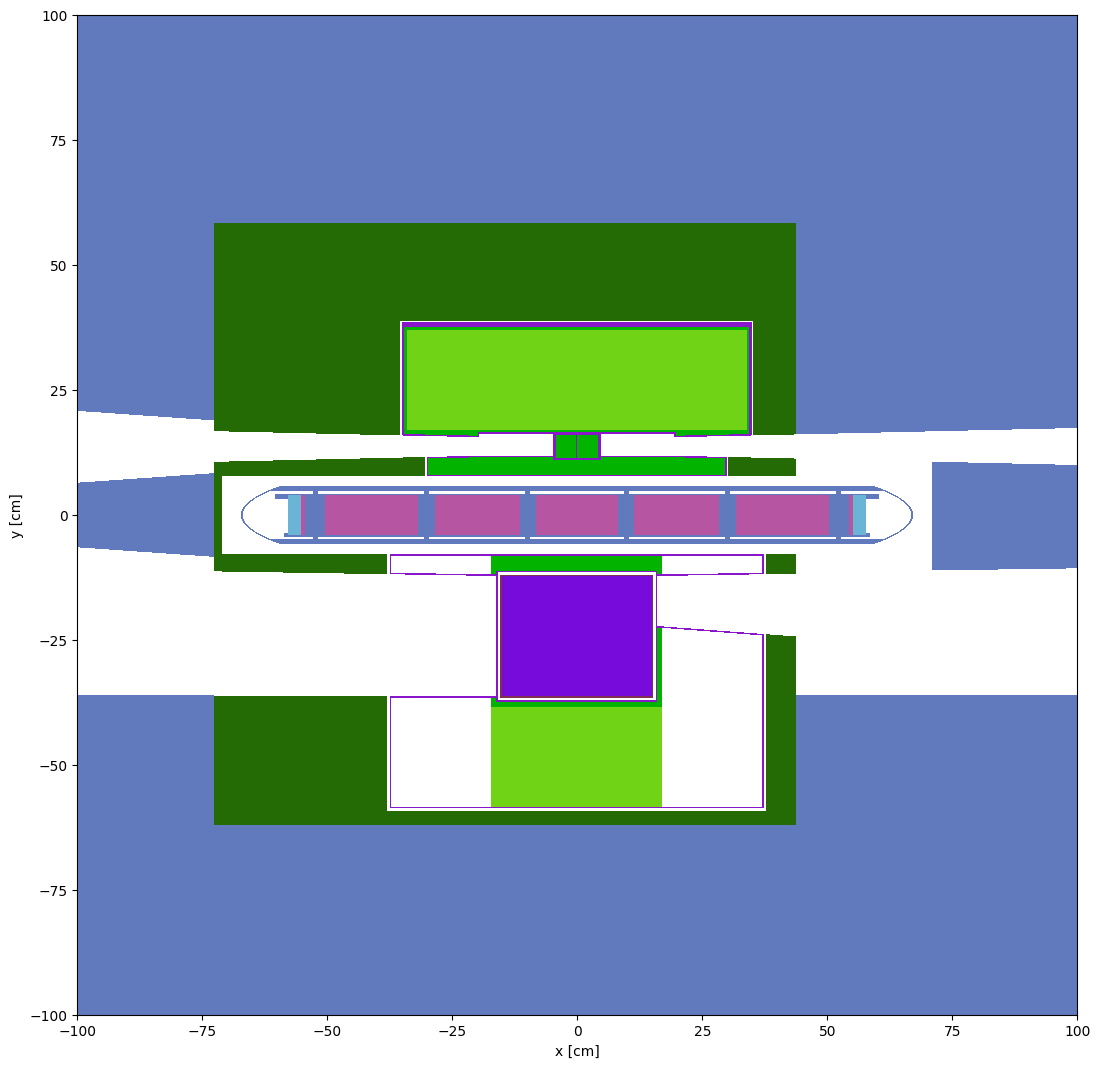

In [8]:
uni1.plot(width=(200,200), pixels=(1000,1000), color_by='material', basis='xy')

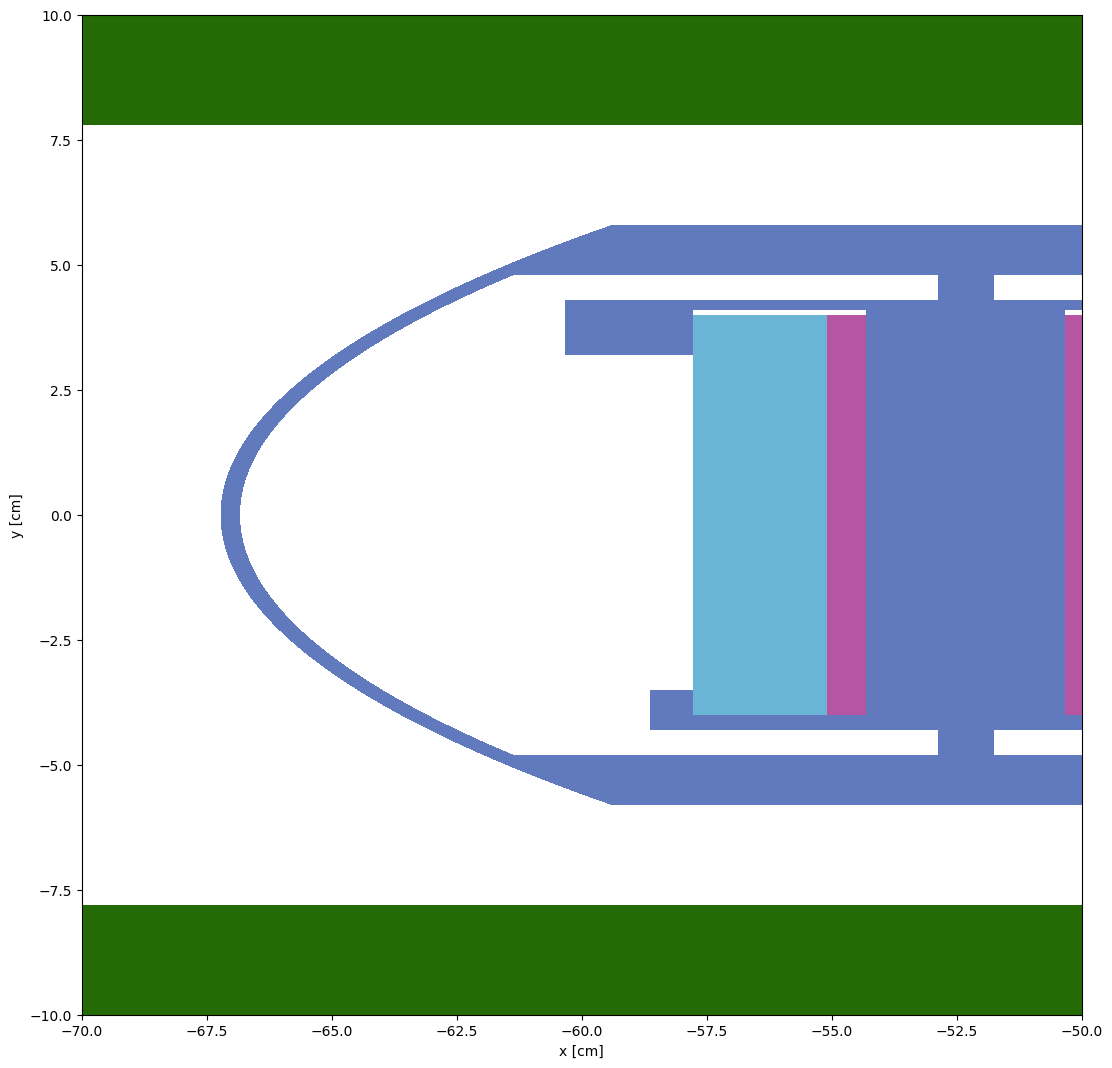

In [9]:
uni1.plot(origin=(-60, 0, 0), width=(20,20), pixels=(1000,1000), color_by='material', basis='xy')

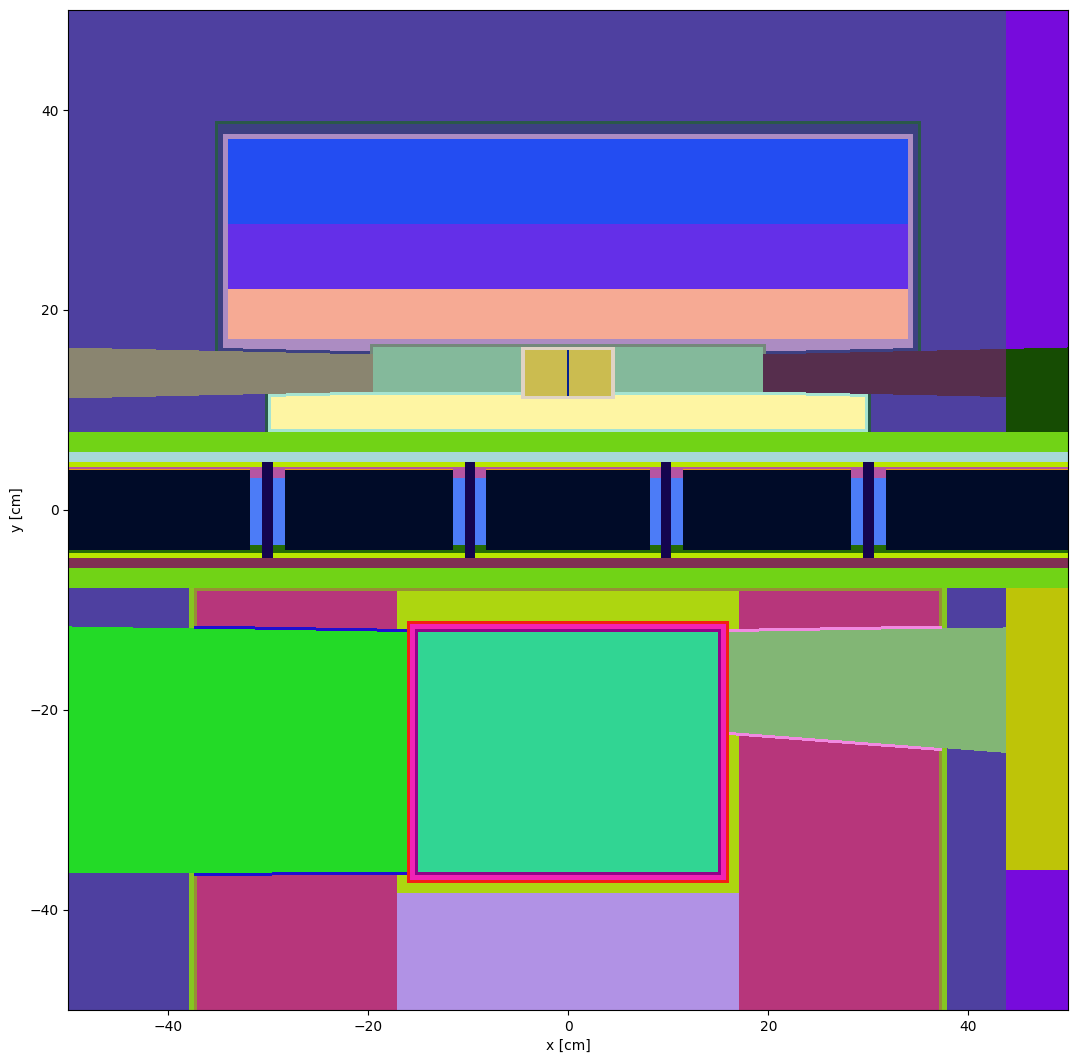

In [10]:
uni1.plot(width=(100,100), pixels=(1000,1000), color_by='cell', basis='xy')

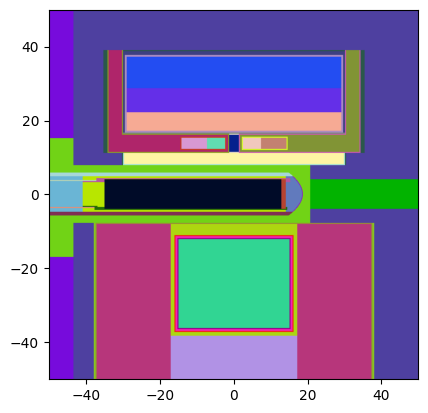

In [11]:
from matplotlib import transforms
fig = plt.figure()
ax = fig.add_subplot(111)
tr = transforms.Affine2D().rotate_deg(90)
uni1.plot(width=(100,100), pixels=(1000,1000), color_by='cell', basis='yz', axes=ax, transform=tr + ax.transData)

Now we will create new NCrystal materials for the moderator, ad we will search and replace the moderator materials in the original model:

In [12]:
# NCrystal materials
cfg_d2 = "ESS-oD2-20K.ncmat"
name_d2 = '100% ortho-D2'
nc_mat_d2 = openmc.Material.from_ncrystal(cfg_d2)
nc_mat_d2.name= name_d2

cfg_h2 = "ESS-pH2-20K.ncmat"
name_h2 = '100% para-H2'
nc_mat_h2 = openmc.Material.from_ncrystal(cfg_h2)
nc_mat_h2.name= name_h2

First, we get a list of all the materials in the model:

In [13]:
all_mats = new_geo.get_all_materials()

Then, we make a list of the materials that contain $S(\alpha, \beta)$ tables for liquid hydrogen and deuterium. We want to replace the cells that contain these materials:

In [14]:
ld_mats = [mat for mat in all_mats.values() for sab in mat._sab if sab[0] == 'c_ortho_D']
lh_mats = [mat for mat in all_mats.values() for sab in mat._sab if sab[0] == 'c_para_H']

In [15]:
print(ld_mats)

[Material
	ID             =	102
	Name           =	
	Temperature    =	None
	Density        =	0.163 [g/cm3]
	Volume         =	None [cm^3]
	S(a,b) Tables  
	S(a,b)         =	('c_ortho_D', 1.0)
	Nuclides       
	H2             =	1.0          [ao]
]


In [16]:
print(lh_mats)

[Material
	ID             =	101
	Name           =	
	Temperature    =	None
	Density        =	0.07 [g/cm3]
	Volume         =	None [cm^3]
	S(a,b) Tables  
	S(a,b)         =	('c_para_H', 1.0)
	Nuclides       
	H1             =	1.0          [ao]
]


We now get all the cells, and then make a list of the ones that are filled with the materials previously searched

In [17]:
all_cells = new_geo.get_all_cells()

In [18]:
# Search all cells with ortho deuterium and replace the material with NCrystal ortho Deuterium
Lower_Moderator_Cells = [cell for cell in all_cells.values() if cell.fill in ld_mats ]

change_materials = True

for cell in Lower_Moderator_Cells:
    if change_materials:
            all_cells[cell.id].fill = nc_mat_d2
    
# Search all cells with ortho deuterium and replace the material with NCrystal ortho Deuterium
Upper_Moderator_Cells = [cell for cell in all_cells.values() if cell.fill in lh_mats ]

for cell in Upper_Moderator_Cells:
    if change_materials:
            all_cells[cell.id].fill = nc_mat_d2

In [19]:
print(Upper_Moderator_Cells)

[Cell
	ID             =	80001
	Name           =	
	Fill           =	Material 1
	Region         =	(((18001 -18002 28001 -28002 -38001 -38002 -38003 -38004) | (18001 -18002 -58101) | (18001 -18002 -58102) | (18001 -18002 -58103)) (-8011 | 8013 | -18001 | 18002 | -28035 | 28037) (8012 | -8014 | -18001 | 18002 | -28035 | 28037) (-8013 | 8014 | -18001 | 18002 | 28002 | -28039))
	Rotation       =	None
	Temperature    =	None
	Translation    =	None
	Volume         =	None
, Cell
	ID             =	80002
	Name           =	
	Fill           =	Material 1
	Region         =	((-10062 38049 -58125) | (28002 -38049 -68001))
	Rotation       =	None
	Temperature    =	None
	Translation    =	None
	Volume         =	None
, Cell
	ID             =	80003
	Name           =	
	Fill           =	Material 1
	Region         =	((-10062 38049 -58127) | (28002 -38049 -68003))
	Rotation       =	None
	Temperature    =	None
	Translation    =	None
	Volume         =	None
, Cell
	ID             =	80012
	Name           =	
	Fill    

In [20]:
print(Lower_Moderator_Cells)

[Cell
	ID             =	85001
	Name           =	
	Fill           =	Material 1
	Region         =	(-18501 18502 -58501)
	Rotation       =	None
	Temperature    =	None
	Translation    =	None
	Volume         =	None
]


In order to calculate fluxes we need the volumes of the cells. We will use the stochstic calculation of OpenMC to find them:

In [21]:
lower_left = (-25, -40, -25.)
upper_right = (25, 20, 20.)
vol_calc = openmc.VolumeCalculation(Lower_Moderator_Cells+Upper_Moderator_Cells, 1000000, lower_left, upper_right )

settings = openmc.Settings()
settings.volume_calculations = [vol_calc]
settings.temperature = {'method':'nearest', 'tolerance':1000} # to avoid problems with neutron libraries

!rm tallies.xml
model = openmc.model.Model(geometry=new_geo, settings=settings)
model.export_to_xml()

rm: cannot remove 'tallies.xml': No such file or directory


In [22]:
!rm summary.h5
openmc.calculate_volumes()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [23]:
vol_calc.load_results('volume_1.h5')

In [24]:
print(vol_calc.volumes)

{80001: 511.65+/-8.295237445516554, 80002: 20.925+/-1.6806061836060822, 80003: 25.515+/-1.8557677615410286, 80012: 517.86+/-8.345233431150982, 80013: 44.685+/-2.4557032090167166, 80014: 40.5+/-2.3379178236199833, 85001: 16934.129999999997+/-44.714011127867956}


We will now complete the simulation with volumetric flux tallies in the upper and lower moderators, and a simple point source in the origin where the proton beam will hit the target. 

In [25]:
tally1a = openmc.Tally()
filter1a = openmc.CellFilter(Lower_Moderator_Cells)
filter2 = openmc.EnergyFilter(np.geomspace(1e-4, 100, 120))
tally1a.scores = ['flux']
tally1a.name = 'lower moderator spectrum'
tally1a.filters = [filter1a, filter2]

tally1b = openmc.Tally()
filter1b = openmc.CellFilter(Upper_Moderator_Cells)
tally1b.scores = ['flux']
tally1b.name = 'upper moderator spectrum'
tally1b.filters = [filter1b, filter2]


tally2 = openmc.Tally()
mesh = openmc.mesh.RectilinearMesh()
mesh.x_grid = np.linspace(-50, 50, 100)
mesh.y_grid = np.linspace(-50, 50, 100)
mesh.z_grid = np.linspace(-2, 2, 2)
filter3 = openmc.MeshFilter(mesh)
filter4 = openmc.EnergyFilter((0,10e-3))
tally2.scores = ['flux']
tally2.name = 'meshtally cold'
tally2.filters = [filter3, filter4]

tallies = openmc.Tallies([tally1a, tally1b, tally2])

In [26]:
settings = openmc.Settings()

source = openmc.Source()
source.space = openmc.stats.Point()
source.angle = openmc.stats.Isotropic()
source.energy = openmc.stats.Discrete([1.0e6], [1.0]) # 1 MeV monoenergetic

settings.source = source

settings.run_mode = 'fixed source'
settings.batches = 10
settings.particles = 100000
settings.temperature = {'method':'nearest', 'tolerance':1000} # to avoid problems with neutron libraries

In [27]:
model = openmc.model.Model(geometry=new_geo, settings=settings, tallies=tallies)
model.export_to_xml()

In [28]:
!rm summary.h5 statepoint.*.h5 tracks.h5
openmc.run(threads=8)

rm: cannot remove 'tracks.h5': No such file or directory
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################    

We will now process the tallies, accumulating the results for the cells that form the upper and lower moderator with the `tally.summation()` method. Each of the tallies will be divided by the corresponding volume:

In [29]:
sp = openmc.StatePoint('statepoint.10.h5')

Text(0, 0.5, 'Average group flux [u.a.]')

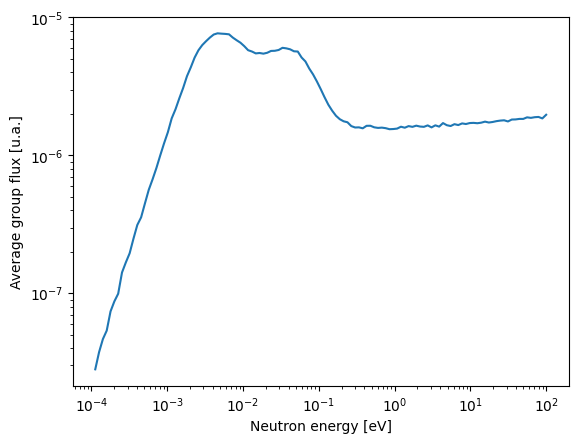

In [30]:
tally = sp.get_tally(name='lower moderator spectrum')
tally = tally.summation(filter_type=openmc.CellFilter, remove_filter=True)

lm_indices = [c.id for c in Lower_Moderator_Cells]
vol = sum([v for i, v in vol_calc.volumes.items() if i in lm_indices])

df = tally.get_pandas_dataframe()
phi_g = df['mean'].values/vol.nominal_value
E_g = df['energy high [eV]'].values
plt.loglog(E_g, phi_g)
plt.xlabel('Neutron energy [eV]')
plt.ylabel('Average group flux [u.a.]')

Text(0, 0.5, 'Average group flux [u.a.]')

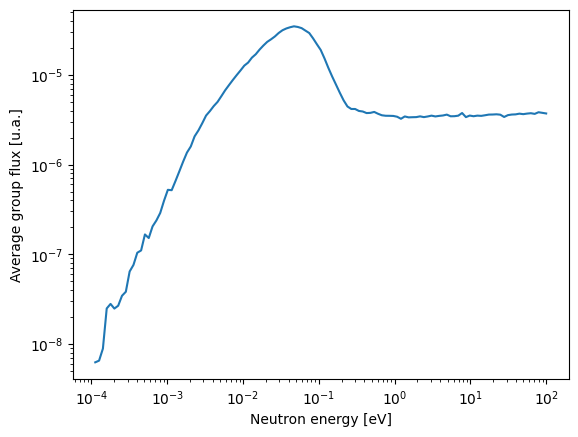

In [31]:
tally = sp.get_tally(name='upper moderator spectrum')
tally = tally.summation(filter_type=openmc.CellFilter, remove_filter=True)

um_indices = [c.id for c in Upper_Moderator_Cells]
vol = sum([v for i, v in vol_calc.volumes.items() if i in um_indices])

df = tally.get_pandas_dataframe()
phi_g = df['mean'].values/vol.nominal_value
E_g = df['energy high [eV]'].values
plt.loglog(E_g, phi_g)
plt.xlabel('Neutron energy [eV]')
plt.ylabel('Average group flux [u.a.]')